In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as torch_functions

from torchvision import models
import os
import numpy as np
from PIL import Image
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
!pip install ThreadedFileLoader


In [2]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

In [3]:
!rm -r tin*
!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip -q -o 'tiny-imagenet-200.zip'

--2022-05-04 17:52:26--  http://cs231n.stanford.edu/tiny-imagenet-200.zip
Resolving cs231n.stanford.edu (cs231n.stanford.edu)... 171.64.68.10
Connecting to cs231n.stanford.edu (cs231n.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248100043 (237M) [application/zip]
Saving to: ‘tiny-imagenet-200.zip’

tiny-imagenet-200.z 100%[===================>] 236.61M  38.0MB/s    in 9.2s    

2022-05-04 17:52:35 (25.8 MB/s) - ‘tiny-imagenet-200.zip’ saved [248100043/248100043]



In [4]:
DATA_DIR = 'tiny-imagenet-200'

TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VALID_DIR = os.path.join(DATA_DIR, 'val')

In [5]:
train_data = datasets.ImageFolder(TRAIN_DIR, transform = ToTensor())
test_data = datasets.ImageFolder(VALID_DIR, transform = ToTensor())

In [6]:
train_idx = []
test_idx = []
train_images = []
train_labels = []
test_images = []
test_labels = []
for i in range(0,10):
    j = 1
    train_indices = []
    test_indices = []
    while j:
        if train_data[j][1] == i:
            if len(train_indices) < 100:
                train_indices.append(j)
            elif len(test_indices) < 10:
                test_indices.append(j)
            if len(train_indices) == 100 and len(test_indices) == 10:
                break
        j += 1
    train_idx.extend(train_indices)
    test_idx.extend(test_indices)

for index in train_idx:
    train_images.append(train_data[index][0].view(train_data[index][0].shape))
    train_labels.append(train_data[index][1])

for index in test_idx:
    test_images.append(train_data[index][0].view(train_data[index][0].shape))
    test_labels.append(train_data[index][1])

In [7]:
# print(test_data[1900][1])
print(f'Training images size - {len(train_idx)}')
print(f'Shape : ',train_images[0].shape)
print(f'Type : {type(train_images)}')
print(f'Testing images size - {len(test_idx)}')
print(f'Shape : ',test_images[0].shape)
print(f'Type : {type(test_images)}')

Training images size - 1000
Shape :  torch.Size([3, 64, 64])
Type : <class 'list'>
Testing images size - 100
Shape :  torch.Size([3, 64, 64])
Type : <class 'list'>


In [8]:
# class AlexNet():
#     def __init__(self):
#         self.alexnet = models.alexnet(pretrained=False)
#         print('== Summary ==')
#         print(self.alexnet.eval())
#     def feed_forward(self, x):
#         x = self.alexnet.features(x)
#         x = self.alexnet.avgpool(x)
#         x = x.view(x.size(0),256*6*6)
#         outputs = self.alexnet.classifier(x)
#         return outputs

class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=8, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 1000),
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        x = torch_functions.softmax(x,dim=1)

        return torch.Tensor(x)

alexnet = AlexNet()
alexnet.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(8, 8), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, in

In [9]:
resnet50 = models.resnet50(pretrained=False)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# test_image.resize(64,64,3)
# print(test_image.shape)
# # test_image = torch.Tensor(test_image)
# test_image = train_transforms(Image.fromarray(test_image))
# alexnet.feed_forward(test_image)

In [11]:
loss_fn = nn.CrossEntropyLoss()
batch_size = 10
num_epochs = 5
lr_ = 0.001
import random

def test(model,x_test,y_test):
    output = model.forward(torch.stack(x_test))
    y_pred = torch.max(output,1)[1].data.squeeze()
    # print(y_pred)
    # print(output)
    acc = 0
    for i in range(len(y_test)):
        if int(y_pred[i]) == y_test[i]:
            acc += 1
    return acc/len(y_test)

def train(num_epochs, model, optimizer,display=False):
    epochs = []
    train_errors = []
    test_errors = []
    tsne_util = []

    output = None
    output1 = None
    outputLast = None

    for epoch in range(num_epochs):
        
        temp_images,temp_labels = np.array(train_images),np.array(train_labels)
        zipped = list(zip(temp_images,temp_labels))
        random.shuffle(zipped)
        shuffled_images,shuffled_labels = zip(*zipped)

        for i in range(10):
            images = shuffled_images[i*batch_size:(i+1)*batch_size]
            labels = shuffled_labels[i*batch_size:(i+1)*batch_size]
            output = model.forward(torch.stack(images))
            # print(f'output : {output}')
            labels = torch.from_numpy(np.array(labels)).long()
            loss = loss_fn(output,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f'loss after epoch-{epoch} : {loss}')
        if epoch == 0:
            output1 = model.forward(torch.stack(test_images))
        if epoch == num_epochs-1:
            outputLast = model.forward(torch.stack(test_images))

        # activation_map = model.get_activation_midway(test_images[0].reshape(1,1,28,28))
        # activation_map = np.array(activation_map.detach().numpy()).reshape(14,14,4)
        epochs.append(epoch)
        train_acc = test(model,train_images,train_labels)
        train_errors.append(1-train_acc)
        test_acc = test(model,test_images,test_labels)
        test_errors.append(1-test_acc)
        if display:
            print(f'Epoch - {epoch+1} Train Accuracy : {train_acc} Test Accuracy : {test_acc}')
            # plt.imshow(activation_map[:,:,:1].reshape(14,14),cmap='gray')
            plt.show()
    return epochs,train_errors,test_errors,[output1,outputLast]
# alexnet.feed_forward(training)

In [12]:
print('=== AlexNet ===')
optimizer = torch.optim.RMSprop(alexnet.parameters(), lr = lr_, alpha=0.9)
epochs,train_errors_1,test_errors_1,tsne_1data = train(num_epochs,alexnet,optimizer)

print("=== ResNet50 ===")
optimizer = torch.optim.RMSprop(resnet50.parameters(), lr = lr_, alpha=0.9)
epochs,train_errors_2,test_errors_2,tsne_2data = train(num_epochs,resnet50,optimizer)

=== AlexNet ===


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


loss after epoch-0 : 6.709470272064209
loss after epoch-1 : 6.809470176696777
loss after epoch-2 : 6.809470176696777
loss after epoch-3 : 6.809470176696777
loss after epoch-4 : 6.609470367431641
=== ResNet50 ===
loss after epoch-0 : 2.542703628540039
loss after epoch-1 : 4.089478969573975
loss after epoch-2 : 4.420095443725586
loss after epoch-3 : 2.163879156112671
loss after epoch-4 : 3.060858964920044


10 epochs are leading to better results, but is taking too much of time.

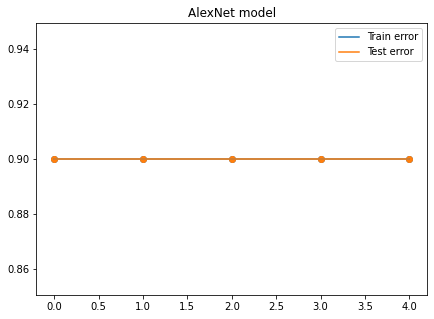

Accuracy for AlexNet model :  0.1


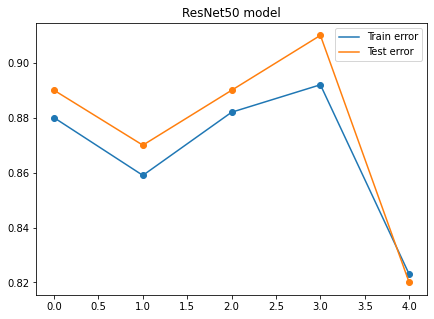

Accuracy for RestNet50 :  0.1


In [13]:
# function to plot graphs
def plot_graphs(epochs,train_errors,test_errors,title_string):
    plt.rcParams["figure.figsize"] = (7,5)
    plt.scatter(epochs,train_errors)
    plt.plot(epochs,train_errors,label='Train error')

    plt.scatter(epochs,test_errors)
    plt.plot(epochs,test_errors,label='Test error')

    plt.title(title_string)
    plt.legend()
    plt.show()

plot_graphs(epochs,train_errors_1,test_errors_1,"AlexNet model")
accuracy_1 = test(alexnet,test_images,test_labels)
print(f'Accuracy for AlexNet model : ',accuracy_1)

plot_graphs(epochs,train_errors_2,test_errors_2,"ResNet50 model")
accuracy_2 = test(alexnet,test_images,test_labels)
print(f'Accuracy for RestNet50 : ',accuracy_2)

In [14]:
from sklearn.manifold import TSNE

def plot_tsne_graphs(tsne_input,msg):
    plt.rcParams["figure.figsize"] = (7,5)
    tsne_output = TSNE(n_components=2,n_iter=400,init='random',learning_rate='auto',random_state=0).fit_transform(tsne_input[0].detach().numpy())
    labels = {}
    for i in range(len(tsne_output)):
        label = test_labels[i]
        if label in labels:
            labels[label].append(tsne_output[i])
        else:
            labels[label] = [tsne_output[i]]
    # print(len(labels.keys()))
    for label_ in labels:
        plt.scatter(np.array(labels[label_])[:,0],np.array(labels[label_])[:,1],label=label_)
    plt.title('tsne plot for '+msg+' first epoch')
    plt.legend()
    plt.show()

    tsne_output = TSNE(n_components=2,n_iter=400,init='random',learning_rate='auto',random_state=0).fit_transform(tsne_input[1].detach().numpy())
    labels = {}
    for i in range(len(tsne_output)):
        label = test_labels[i]
        if label in labels:
            labels[label].append(tsne_output[i])
        else:
            labels[label] = [tsne_output[i]]
    for label_ in labels:
        plt.scatter(np.array(labels[label_])[:,0],np.array(labels[label_])[:,1],label=label_)
    plt.title('tsne plot for '+msg+' last epoch')
    plt.legend()
    plt.show()

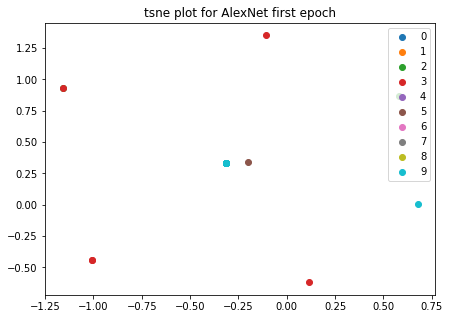

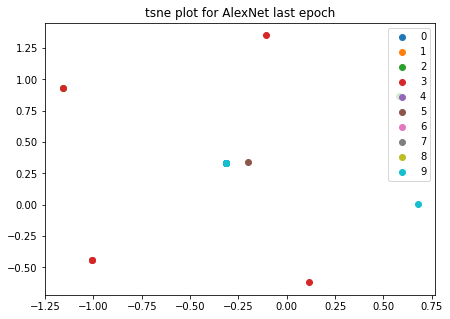

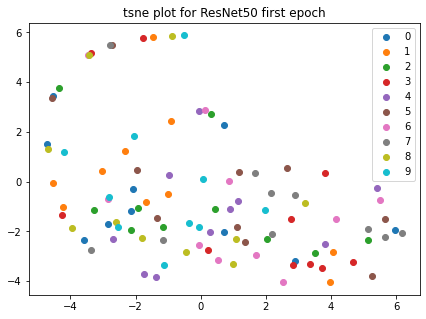

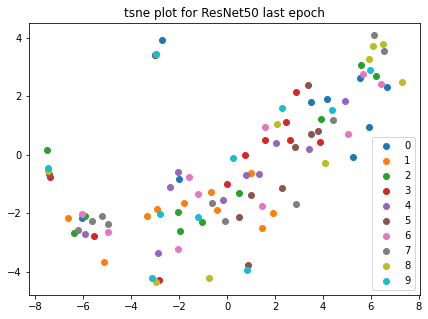

In [15]:
plot_tsne_graphs(tsne_1data,'AlexNet')
plot_tsne_graphs(tsne_2data,'ResNet50')


Computationally both are too expensive, as there are many many layers and a lot of computation is need to be done. Out of the two, I prefer alexnet model as it is acheiving a better result(after many epochs) similar to resnet50 but with relatively less amount of time. 